# Plot and comparisons

In [1]:
library(tidyverse)
library(ggpubr)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
save_plot <- function(p, fn, w=7, h=6){
    for(ext in c(".pdf", ".png", ".svg")){
        ggsave(filename=paste0(fn,ext), plot=p, width=w, height=h)
    }
}


get_ml_summary <- function(fn){
    ml_df = data.table::fread(fn) %>% mutate_at("fold", as.character) %>%
        select(fold, n_features, n_redundant, starts_with("test_score_r2")) %>%
        pivot_longer(-fold) %>% group_by(name) %>%
        summarise(Mean=mean(value), Median=median(value), Std=sd(value), .groups = "keep")
    return(ml_df)
}


get_metrics <- function(filename, tissue){
    datalist = list()
    for(fn in Sys.glob(filename)){
        gene_id = str_extract(fn, "ENSG\\d+_\\d+")
        dat <- get_ml_summary(fn)
        dat["Geneid"] = gene_id
        datalist[[gene_id]] <- dat
    }
    ml_df <- bind_rows(datalist)
    ml_df["Tissue"] = tissue
    return(ml_df)
}

## Load metrics

### Random forest

In [11]:
rf = data.table::fread("../../rf/summary_10Folds_allTissues.tsv") %>%
    as.data.frame %>% mutate_if(is.character, as.factor) %>%
    mutate_at("fold", as.character) %>%
    select(tissue, feature, fold, n_features, starts_with("test_score_r2")) %>%
    pivot_longer(-c(tissue, feature, fold), names_to="metric", values_to="score") %>%
    group_by(tissue, feature, metric) %>%
    summarise(Mean=mean(score), Median=median(score), Std=sd(score), .groups = "keep") %>%
    filter(metric == "test_score_r2") %>% mutate("model"="Random Forest")
dim(rf)
rf %>% head(2)

[1] 9324    7

tissue,feature,metric,Mean,Median,Std,model
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
Caudate,ENSG00000003249_13,test_score_r2,-0.002856899,0.03781765,0.1982073,Random Forest
Caudate,ENSG00000003509_15,test_score_r2,-0.128148560,-0.06360597,0.1504515,Random Forest


### Elastic net

In [12]:
enet = data.table::fread("../../enet/summary_10Folds_allTissues.tsv") %>%
    as.data.frame %>% mutate_if(is.character, as.factor) %>%
    mutate_at("fold", as.character) %>%
    select(tissue, feature, fold, n_features, starts_with("test_score_r2")) %>%
    pivot_longer(-c(tissue, feature, fold), names_to="metric", values_to="score") %>%
    group_by(tissue, feature, metric) %>%
    summarise(Mean=mean(score), Median=median(score), Std=sd(score), .groups = "keep") %>%
    filter(metric == "test_score_r2") %>% mutate("model"="Elastic Net")
dim(enet)
enet %>% head(2)

[1] 9324    7

tissue,feature,metric,Mean,Median,Std,model
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
Caudate,ENSG00000003249_13,test_score_r2,0.001441153,0.06698573,0.23025029,Elastic Net
Caudate,ENSG00000003509_15,test_score_r2,-0.028637386,-0.01916360,0.06846977,Elastic Net


## Annotate

In [29]:
dtu = data.table::fread(paste0("../../../../../differential_analysis/tissue_comparison/",
                               "ds_summary/_m/diffSplicing_ancestry_FDR05_4regions.tsv")) %>%
    select(gene, Tissue) %>% distinct %>% rename("gene_name"="gene")

degs = data.table::fread("../../../../_m/degs_annotation.txt") %>%
    select(V1, ensemblID, gene_name, Tissue) %>% distinct %>%
    rename("Feature"="V1") %>% inner_join(dtu, by=c("Tissue", "gene_name")) %>%
    rename("tissue"="Tissue") %>% mutate("DTU"="DTU")

In [31]:
df = bind_rows(rf, enet) %>% mutate(Feature=gsub("_", ".", feature)) %>%
    left_join(degs, by=c("tissue", "Feature")) %>% as.data.frame %>%
    mutate(DTU = replace_na(DTU, "DEG")) %>%
    mutate_if(is.character, as.factor)
dim(df)
df %>% head(2)

[1] 18648    11

,tissue,feature,metric,Mean,Median,Std,model,Feature,ensemblID,gene_name,DTU
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Caudate,ENSG00000003249_13,test_score_r2,-0.002856899,0.03781765,0.1982073,Random Forest,ENSG00000003249.13,NA,NA,DEG
2,Caudate,ENSG00000003509_15,test_score_r2,-0.128148560,-0.06360597,0.1504515,Random Forest,ENSG00000003509.15,NA,NA,DEG


## Merge and plot

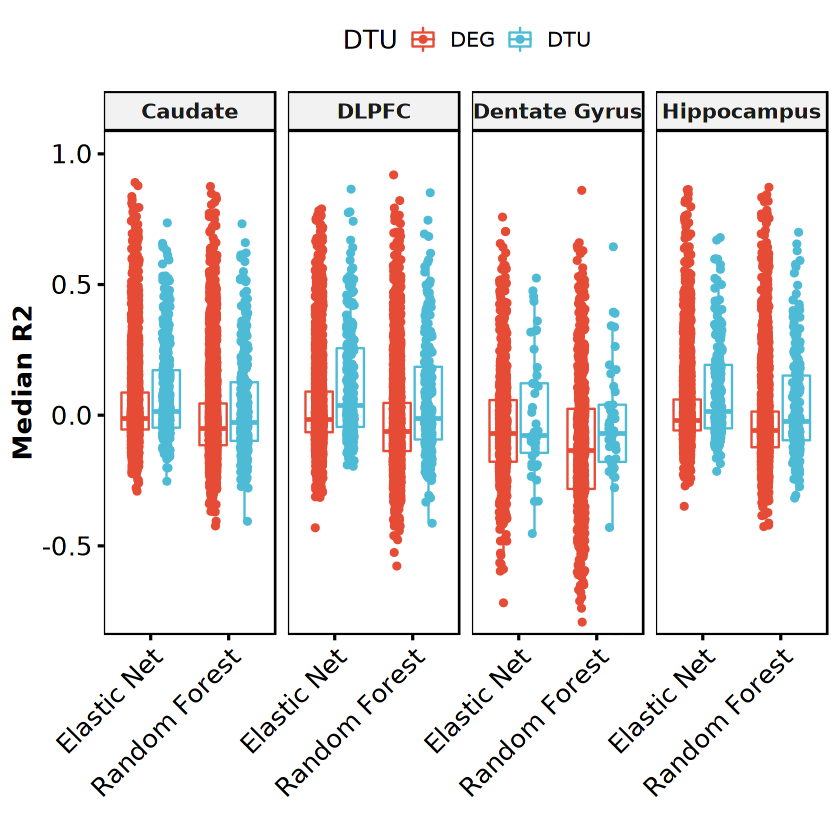

In [45]:
df %>% #filter(DTU == "DTU") %>%
    ggboxplot(x="model", y="Median", color="DTU", add="jitter", 
              facet.by="tissue", palette="npg", ylim=c(-0.75, 1), 
              ylab="Median R2", xlab="",
              panel.labs.font=list(face='bold'), ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")

Don't know how to automatically pick scale for object of type function. Defaulting to continuous.

ERROR while rich displaying an object: Error: Aesthetics must be valid data columns. Problematic aesthetic(s): y = median. 
Did you mistype the name of a data column or forget to add after_stat()?

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2re

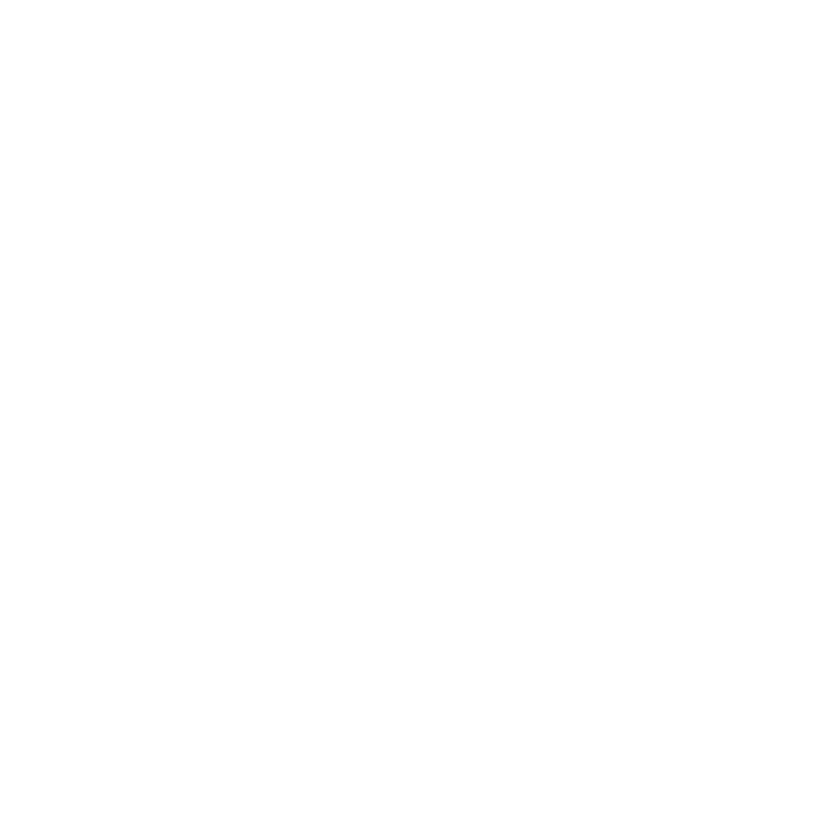

In [33]:
bxp = df %>% ggboxplot(x="tissue", y="median", fill="DTU", add="jitter", 
                       facet.by="model", palette="npg", ylim=c(-0.75, 1), 
                       ylab="Median R2", xlab="", legend="None", 
                       panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
#save_plot(bxp, "summary_boxplots_r2_3methods", 9, 6)
bxp

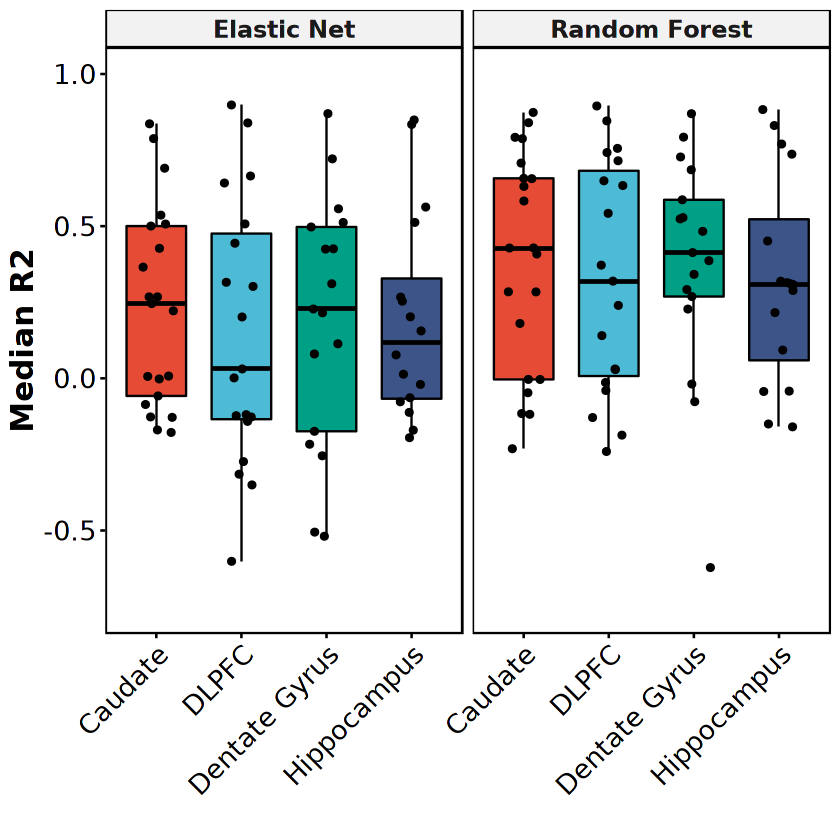

In [10]:
df = bind_rows(raffe, enet)
bxp = df %>% ggboxplot(x="Tissue", y="Median", fill="Tissue", add="jitter", 
                       facet.by="Model", palette="npg", ylim=c(-0.75, 1), 
                       ylab="Median R2", xlab="", legend="None", 
                       panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
save_plot(bxp, "summary_boxplots_r2_2methods", 6, 5)
bxp

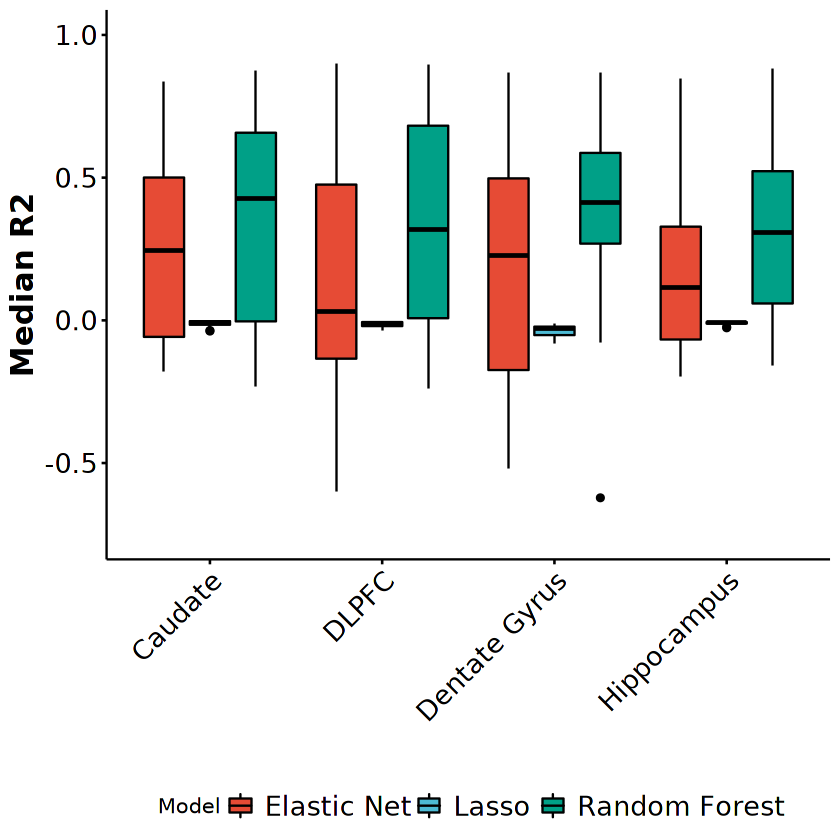

In [18]:
df = bind_rows(raffe, lasso, enet)
bxp = df %>% ggboxplot(x="Tissue", y="Median", fill="Model", 
                       palette="npg", ylim=c(-0.75, 1), 
                       ylab="Median R2", xlab="", legend="bottom", 
                       panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
#save_plot(bxp, "summary_boxplots_r2_2methods_stacked", 6, 5)
bxp

## Reproducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()